In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from typing import Set
import xgboost as xgb

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")



Previous 30 days, but no current data given.   There is no other date that I think we can use to get the preceding 30 days.   I hthink that the best we can do is look at the last trip date in the dataset and assume that there were not any significant dates after that.

In [225]:
df = pd.read_json('ultimate_data_challenge.json', convert_dates=['last_trip_date', 'signup_date'])
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [226]:
df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

50,000 rows and 11 columns

In [227]:
df.shape

(50000, 12)

Contain one month of data from 2014-01-01 to 2014-01-31

In [228]:
df.agg(
    {'signup_date': ['min', 'max'], 'last_trip_date': ['min', 'max']}
).reset_index()

,index,signup_date,last_trip_date
0,min,2014-01-01,2014-01-01
1,max,2014-01-31,2014-07-01


16% of avg_rating_of_drive (8122 records) are null
0.4 % of avg_rating_by_drive (201 records) are null


In [229]:
df.isna().sum().sort_values(ascending=False)

avg_rating_of_driver      8122
phone                      396
avg_rating_by_driver       201
city                         0
trips_in_first_30_days       0
signup_date                  0
avg_surge                    0
last_trip_date               0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
dtype: int64

In [230]:


# look for nulls
df.city.value_counts(dropna=False)

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [231]:
# look for nulls
df.isna().sum().sort_values(ascending=False)

avg_rating_of_driver      8122
phone                      396
avg_rating_by_driver       201
city                         0
trips_in_first_30_days       0
signup_date                  0
avg_surge                    0
last_trip_date               0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
dtype: int64

In [232]:
today = df['last_trip_date'].max()
today

Timestamp('2014-07-01 00:00:00')

Create the retained label

In [233]:
from datetime import timedelta

# Calculate the maximum last_trip_date
max_last_trip_date = df['last_trip_date'].max()

# Calculate the date 30 days ago from the maximum last_trip_date
cutoff_date = max_last_trip_date - timedelta(days=30)



df['retained'] = np.where(df['last_trip_date'] > cutoff_date, 1, 0)


In [234]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


Verify columns for ML  

avg_dist: numeric

In [235]:
df.avg_dist.value_counts(dropna=False)

0.00     150
2.29     116
2.30     116
2.36     114
2.73     114
        ... 
25.07      1
22.34      1
25.43      1
25.78      1
30.39      1
Name: avg_dist, Length: 2908, dtype: int64

weekday_pct: numeric 

In [236]:
df.weekday_pct.value_counts(dropna=False)

100.0    16659
0.0       9203
50.0      4057
66.7      2088
33.3      1619
         ...  
29.5         1
93.6         1
50.5         1
47.9         1
10.7         1
Name: weekday_pct, Length: 666, dtype: int64

ultimate_black_user: binary - one-hot encode

In [237]:
df.ultimate_black_user.value_counts(dropna=False)

False    31146
True     18854
Name: ultimate_black_user, dtype: int64

phone: Although there are 396 records with no phone value, this could be an interesting indicator—so we have to categorize this one I think we create a third category for the tiny amount of missing records

In [238]:
df.phone.value_counts(dropna=False)

iPhone     34582
Android    15022
None         396
Name: phone, dtype: int64

surge_pct:  % 367 values - leave as a numeric

In [239]:
df.surge_pct.value_counts(dropna=False)

0.0      34409
100.0     1416
50.0      1367
33.3      1152
25.0       906
         ...  
48.1         1
14.9         1
42.4         1
0.4          1
35.2         1
Name: surge_pct, Length: 367, dtype: int64

avg_surge: surge 115 values - leave as a numeric

In [240]:
df.avg_surge.value_counts(dropna=False)

1.00    34454
1.25     1100
1.13      956
1.02      809
1.08      798
        ...  
1.77        1
4.75        1
1.90        1
1.51        1
3.63        1
Name: avg_surge, Length: 115, dtype: int64

avg_rating_by_driver: 28 numeric values for avg_rating_by_driver - could be a category or a numeric

In [241]:
df.avg_rating_by_driver.value_counts(dropna=False)

5.0    28508
4.8     4537
4.7     3330
4.9     3094
4.5     2424
4.6     2078
4.0     1914
4.3     1018
4.4      860
3.0      602
4.2      342
NaN      201
3.5      199
3.7      195
1.0      181
2.0      126
4.1      125
3.8      111
3.3       47
3.9       41
2.5       31
3.6       19
3.4        5
1.5        4
2.8        3
3.2        2
2.7        2
2.3        1
Name: avg_rating_by_driver, dtype: int64

avg_rating_of_driver: Avg driver rating has 38 fields - category?

In [242]:
df.avg_rating_of_driver.value_counts(dropna=False)

5.0    20771
NaN     8122
4.0     4193
4.5     2498
4.8     2430
4.7     1945
4.9     1771
4.3     1487
4.6     1143
3.0     1003
4.4      829
4.2      601
3.5      488
3.8      428
4.1      398
3.7      364
1.0      256
3.9      255
2.0      209
3.3      201
3.6      172
3.4      108
2.5       94
3.2       53
2.7       47
3.1       39
2.8       28
2.3       22
2.9       13
2.6       12
2.1        6
1.5        4
2.4        3
1.7        2
1.8        2
1.9        1
1.6        1
2.2        1
Name: avg_rating_of_driver, dtype: int64

city:  Only three cities and no nulls, so that can be categorized

In [243]:
df.city.value_counts(dropna=False)

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

trips_in_first_30_days:  this is essentially continuous numeric but there are only 9 unique values -- can also be categorized ... if we want to

In [244]:
df.trips_in_first_30_days.value_counts(dropna=False)

0      15390
1      14108
2       7402
3       3788
4       2562
5       1616
6       1134
7        819
8        589
9        471
10       349
11       301
12       221
13       168
15       155
14       147
17       113
16       108
18        80
19        69
20        51
23        45
21        40
22        34
24        33
27        28
28        21
25        20
26        19
30        15
34        11
29         9
37         9
33         9
32         8
31         6
44         5
40         5
43         4
38         4
39         3
36         3
47         3
42         3
53         2
48         2
49         2
55         2
35         2
54         2
56         2
71         1
73         1
125        1
41         1
50         1
63         1
51         1
58         1
Name: trips_in_first_30_days, dtype: int64


Scale and maybe normalize
avg_rating_by_driver: float : 28 numeric values for avg_rating_by_driver - could be a category or a numeric. - fillna with ... average over population
avg_rating_of_driver: float :Avg driver rating has 38 fields - category?  fillna with ... average over population
avg_surge: float : surge 115 values - leave as a numeric
surge_pct:  % 367 values - leave as a numeric
avg_dist: float : numeric
weekday_pct: float :  numeric 

Categorize encoding
phone: Although there are 396 records with no phone value=- fill with 'Other'
city:  object - Only three cities and no nulls, so that can be categorized
trips_in_first_30_days: this is essentially continuous numeric but there are only 9 unique values -- can also be one-hot encoded ... if we want to

Pull out month and may calculate duration (e.g. duration sicen signup)
signup_date : datetime : break into components?   month,... day?
last_trip_date : datetime : date components - month, maybe intervals from signup?


ultimate_black_user: bool : transform to 1,0 binary - one-hot encode




df[‘ScheduledDay_year’] = df[‘ScheduledDay’].dt.year
df[‘ScheduledDay_month’] = df[‘ScheduledDay’].dt.month
df[‘ScheduledDay_week’] = df[‘ScheduledDay’].dt.week
df[‘ScheduledDay_day’] = df[‘ScheduledDay’].dt.day
df[‘ScheduledDay_hour’] = df[‘ScheduledDay’].dt.hour
df[‘ScheduledDay_minute’] = df[‘ScheduledDay’].dt.minute
df[‘ScheduledDay_dayofweek’] = df[‘ScheduledDay’].dt.dayofweek
df[‘AppointmentDay_year’] = df[‘AppointmentDay’].dt.year
df[‘AppointmentDay_month’] = df[‘AppointmentDay’].dt.month
df[‘AppointmentDay_week’] = df[‘AppointmentDay’].dt.week
df[‘AppointmentDay_day’] = df[‘AppointmentDay’].dt.day
df[‘AppointmentDay_hour’] = df[‘AppointmentDay’].dt.hour
df[‘AppointmentDay_minute’] = df[‘AppointmentDay’].dt.minute
df[‘AppointmentDay_dayofweek’] = df[‘AppointmentDay’].dt.dayofweek




Prepare data for feature selection

Perform data transformations

In [245]:
# cast to floats
df['trips_in_first_30_days'] = df['trips_in_first_30_days'].astype(float)

# we'll drop dates, but maybe the month of the year could have some importance
df['signup_month'] = df['signup_date'].dt.month
df['last_trip_month'] = df['last_trip_date'].dt.month

# and maybe the length of time from signup to last_trip could have some value as a feature
df['last_trip_days_since_su'] = (df['last_trip_date'] - df['signup_date']).dt.days

# change booleans to int
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

# lower case the phone names and fill the missing phone cells with 'other' 
df['phone'] = np.where(df['phone'].isna(), 'other', df['phone'].str.lower())

# just cosmetically, make the column names lower case with no spaces in the name 
df['city'] = df['city'].str.replace(' ', '_').str.lower()  

# fill the null avg_ columns with the mean - at least for feature selection 
df['avg_rating_by_driver'].fillna( df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna( df['avg_rating_of_driver'].mean(), inplace=True)

In [246]:
features = df.loc[:, df.columns != 'retained']
target = df[['retained']]


In [247]:
import featuretools as ft
from woodwork.logical_types import Categorical


es = ft.EntitySet(id="my_entityset")


# Define the entity for your features (X)
# es = es.entity_from_dataframe(entity_id="features",
#                               dataframe=features,
#                               index=features.index)

# # Define the entity for your target (y)
# es = es.entity_from_dataframe(entity_id="target",
#                               dataframe=target,
#                               index=target.index)

es = es.add_dataframe(
    dataframe_name="features",
    dataframe=features,
    index=features.index,
    time_index="signup_date",
    logical_types={
        "city": Categorical,
        "phone": Categorical,
        "signup_month": Categorical,
        "last_trip_month": Categorical
        
    },
)
es = es.add_dataframe(
    dataframe_name="target",
    dataframe=target,
    index=target.index
)



TypeError: unhashable type: 'RangeIndex'

In [ ]:
es

In [ ]:
# Specify the relationship between features and target (e.g., one-to-many)
relationship = ft.Relationship(es["features"].index,
                               es["target"].index)
es = es.add_relationship(relationship)

# feature_matrix, feature_defs = ft.dfs(entityset=df_encoded,
#                                       target_entity="retained",
#                                       max_depth=3)

# Run deep feature synthesis
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="target")

Encode the data for ML

In [195]:
continuous_columns = [
    'avg_rating_by_driver', 
    'avg_rating_of_driver',
    'avg_surge',    
    'surge_pct',    
    'avg_dist',    
    'weekday_pct',
    'trips_in_first_30_days', 
    'last_trip_days_since_su'
]

category_columns = ['phone', 'city', 'signup_month', 'last_trip_month']



In [196]:
# Perform one-hot encoding on the cat columns
df_encoded = pd.get_dummies(df, columns=category_columns)

# Apply MinMax scaling to the numeric columns
scaler = MinMaxScaler()
df_encoded[continuous_columns] = scaler.fit_transform(df_encoded[continuous_columns])

df_encoded.head()


,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,...,city_king's_landing,city_winterfell,signup_month_1,last_trip_month_1,last_trip_month_2,last_trip_month_3,last_trip_month_4,last_trip_month_5,last_trip_month_6,last_trip_month_7
0,0.032,2014-01-25,0.925,0.014286,2014-06-17,0.154,1,0.462,0.022801,1.000,...,1,0,1,0,0,0,0,0,1,0
1,0.000,2014-01-29,1.000,0.000000,2014-05-05,0.000,0,0.500,0.051317,1.000,...,0,0,1,0,0,0,0,1,0,0
2,0.024,2014-01-06,0.825,0.000000,2014-01-07,0.000,0,1.000,0.004784,1.000,...,0,0,1,1,0,0,0,0,0,0
3,0.072,2014-01-10,0.900,0.020000,2014-06-29,0.200,1,0.800,0.014662,0.975,...,1,0,1,0,0,0,0,0,1,0
4,0.112,2014-01-27,0.850,0.027143,2014-03-15,0.118,0,0.824,0.019446,0.975,...,0,1,1,0,0,1,0,0,0,0


In [197]:

# y = df_encoded.loc[:, 'retained']
# X = df_encoded.loc[:, df_encoded.columns != 'retained']
# X.drop(columns=['signup_date', 'last_trip_date'],inplace=True)
# 




In [198]:
df_encoded.retained.value_counts()

0    31690
1    18310
Name: retained, dtype: int64

In [199]:
features = df.loc[:, df_encoded.columns != 'retained']
target = df[['retained']]


IndexError: Boolean index has wrong length: 26 instead of 16

In [ ]:
features.head()

In [171]:
target.head()

,retained
0,1
1,0
2,0
3,1
4,0


Perform any final validations

In [71]:
assert df.isna().sum().sum() == 0

Ok, now break into features and labels

In [72]:
def plot_heatmap(df):
    numeric_df = df.select_dtypes(include=['number'])
    correlation_matrix = numeric_df.corr()
    plt.figure(figsize=(15, 15))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.title('Heatmap')

    # Set x-axis and y-axis labels
    plt.xticks(np.arange(len(numeric_df.columns)), numeric_df.columns, rotation=45)
    plt.yticks(np.arange(len(numeric_df.columns)), numeric_df.columns)
    plt.show()

Not a lot of internal correlation - likely there's not a huge risk of co-founded features

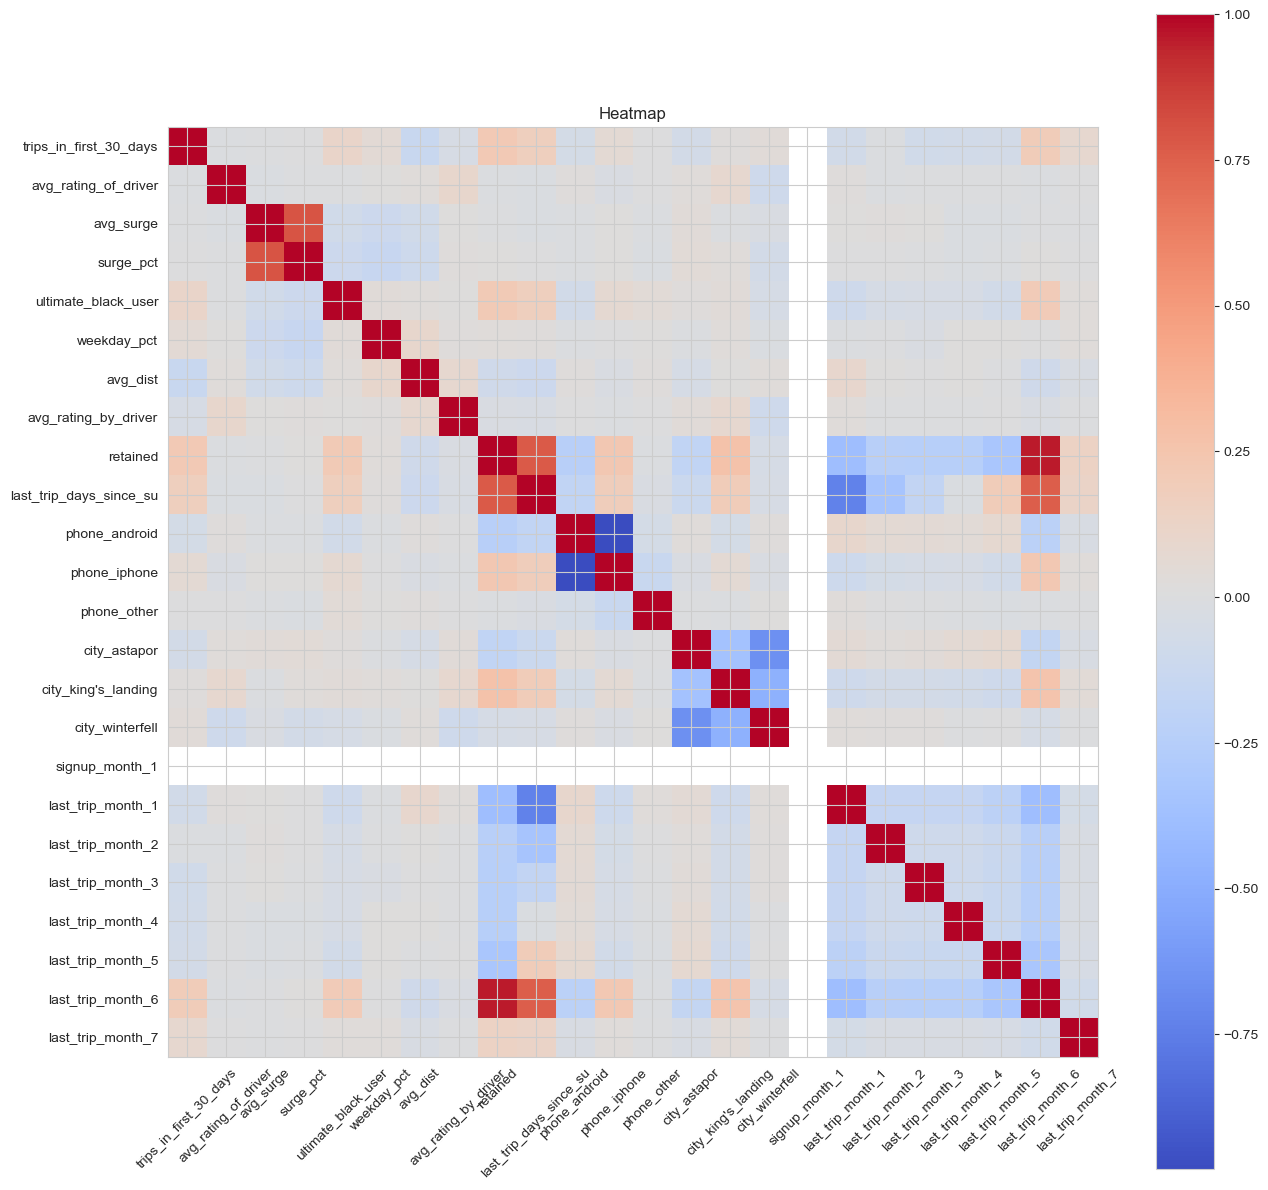

In [73]:
plot_heatmap(df_encoded)

In [74]:
from typing import Set


def correlate_to_target( df: pd.DataFrame, target_column: str, top_n: int) -> (pd.DataFrame, Set):
    # Calculate correlation matrix
    correlation_matrix = df.corr()

    # Filter and sort correlation coefficients by absolute value
    corr_df = pd.DataFrame(correlation_matrix.abs().unstack().sort_values(ascending=False))
    corr_df.reset_index(inplace=True)
    corr_df.columns = ['x', 'y', 'corr']

    not_self_correlated = (corr_df.y != target_column)
    win_correlated = (corr_df.x == target_column)

    df = corr_df.loc[win_correlated & not_self_correlated] \
        .sort_values(by='corr', ascending=False) \
        .drop(columns=['x']) \
        .head(top_n) \
        .copy()

    s = set(df['y'].values)

    return df, s

In [75]:
from typing import Any


def plot_correlations(scores: Any, features: Any, title: str):
    # Plot feature importance
    plt.figure(figsize=(10, 10))
    plt.barh(range(len(scores)), scores, align='center')
    plt.yticks(range(len(features)), features)
    plt.xlabel('Score')
    plt.ylabel('Column')
    plt.title(title)
    plt.show()

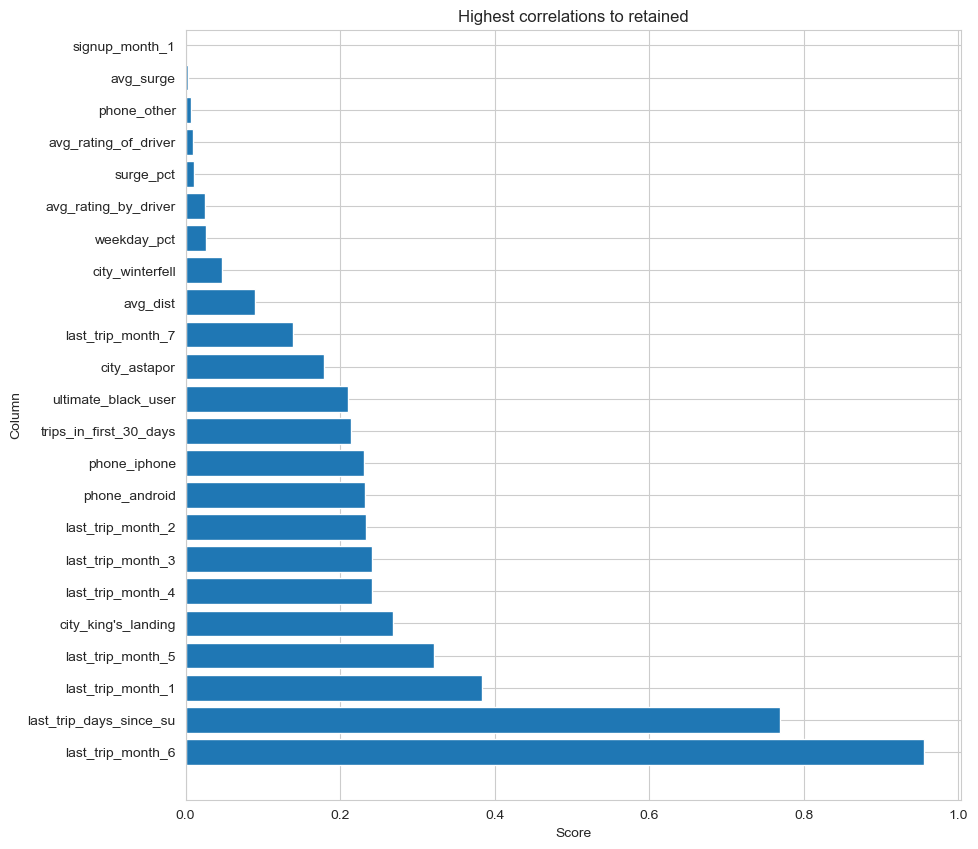

In [76]:
top_correlations, set_correlations = correlate_to_target(df_encoded, 'retained', 30)
plot_correlations(top_correlations['corr'], top_correlations['y'], 'Highest correlations to retained')


In [77]:

def calc_feature_importance(X: pd.DataFrame, y: pd.Series, top_n=30) -> (pd.DataFrame, Set):
    # Create an XGBoost model
    model = xgb.XGBRegressor()

    # Fit the model
    model.fit(X, y)

    # Get feature importance scores
    importance_scores = model.feature_importances_

    # Sort feature importance scores
    sorted_indices = importance_scores.argsort()[::-1]
    sorted_scores = importance_scores[sorted_indices]
    feature_names = X.columns[sorted_indices]

    # Get the top 'n' feature importance scores and names
    top_scores = sorted_scores[:top_n]
    top_features = feature_names[:top_n]
    df = pd.DataFrame({'y': top_features, 'corr': top_scores})

    set_xg_cols = set(top_features)
    return df, set(top_features)

In [78]:
def plot_correlations(scores: Any, features: Any, title: str):
    # Plot feature importance
    plt.figure(figsize=(10, 10))
    plt.barh(range(len(scores)), scores, align='center')
    plt.yticks(range(len(features)), features)
    plt.xlabel('Score')
    plt.ylabel('Column')
    plt.title(title)
    plt.show()

In [79]:
y = df_encoded[['retained']]
X = df_encoded.loc[:, df_encoded.columns != 'retained']

In [81]:
df_encoded.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,last_trip_days_since_su,...,city_king's_landing,city_winterfell,signup_month_1,last_trip_month_1,last_trip_month_2,last_trip_month_3,last_trip_month_4,last_trip_month_5,last_trip_month_6,last_trip_month_7
0,0.032,0.925,0.014286,0.154,1,0.462,0.022801,1.000,1,0.790055,...,1,0,1,0,0,0,0,0,1,0
1,0.000,1.000,0.000000,0.000,0,0.500,0.051317,1.000,0,0.530387,...,0,0,1,0,0,0,0,1,0,0
2,0.024,0.825,0.000000,0.000,0,1.000,0.004784,1.000,0,0.005525,...,0,0,1,1,0,0,0,0,0,0
3,0.072,0.900,0.020000,0.200,1,0.800,0.014662,0.975,1,0.939227,...,1,0,1,0,0,0,0,0,1,0
4,0.112,0.850,0.027143,0.118,0,0.824,0.019446,0.975,0,0.259669,...,0,1,1,0,0,1,0,0,0,0


In [37]:
top_features, set_features = calc_feature_importance(X, y, top_n=30)


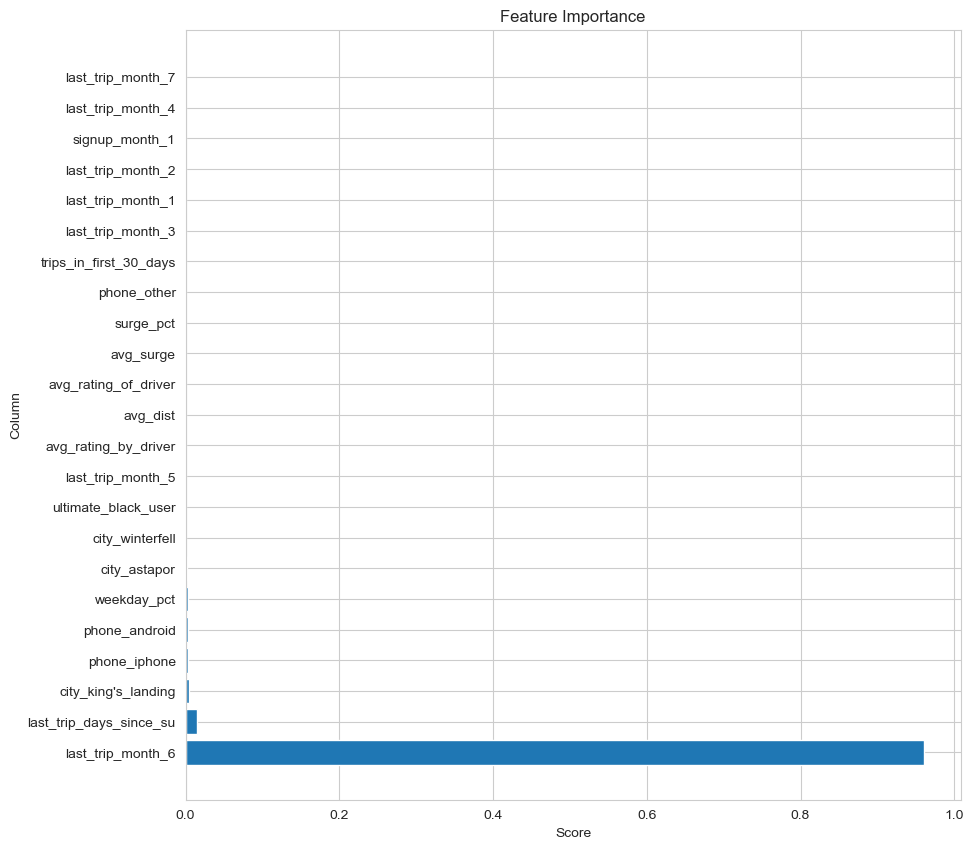

In [38]:
plot_correlations(
    top_features['corr'],
    top_features['y'], "Feature Importance")

In [41]:
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_trip_days_since_su,phone_android,...,city_king's_landing,city_winterfell,signup_month_1,last_trip_month_1,last_trip_month_2,last_trip_month_3,last_trip_month_4,last_trip_month_5,last_trip_month_6,last_trip_month_7
0,0.032,0.925,0.014286,0.154,1,0.462,0.022801,1.000,0.790055,0,...,1,0,1,0,0,0,0,0,1,0
1,0.000,1.000,0.000000,0.000,0,0.500,0.051317,1.000,0.530387,1,...,0,0,1,0,0,0,0,1,0,0
2,0.024,0.825,0.000000,0.000,0,1.000,0.004784,1.000,0.005525,0,...,0,0,1,1,0,0,0,0,0,0
3,0.072,0.900,0.020000,0.200,1,0.800,0.014662,0.975,0.939227,0,...,1,0,1,0,0,0,0,0,1,0
4,0.112,0.850,0.027143,0.118,0,0.824,0.019446,0.975,0.259669,1,...,0,1,1,0,0,1,0,0,0,0


In [43]:
type(y)

pandas.core.series.Series

In [40]:
feature_matrix, feature_defs = ft.dfs(entityset=df_encoded,
                                      target_entity="retained",
                                      max_depth=3)

TypeError: dfs() got an unexpected keyword argument 'target_entity'

In [27]:
from feature_model import create_team_week_model, train_team_week_model

model = create_team_week_model(
    X.shape[1],
    regularization_rate=.001,
    activation_function="relu",
    output_function="sigmoid")

# r = train_team_week_model(model=model, X=X, y=y,
#                           epochs_size=500,
#                           batch_size=32,
#                           verbose=0,
#                           learning_rate=.001,
#                           validation_split=0.25,
#                           # validation_data=(X_test, y_test),
#                           loss_function='binary_crossentropy')

2023-09-14 12:32:23.843672: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-09-14 12:32:23.843696: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-09-14 12:32:23.843700: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-09-14 12:32:23.843731: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-14 12:32:23.843744: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [37]:
from utils_eda import plot_loss, plot_accuracy
plot_loss(r)


NameError: name 'r' is not defined

In [ ]:
plot_accuracy(r)

In [28]:
import shap

# Assuming you have a trained Keras model 'model' and a dataset 'X'
explainer = shap.DeepExplainer(model, data=X.values)




In [ ]:
shap_values = explainer.shap_values(X.values)

2023-09-14 12:32:35.852171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [ ]:
# Calculate the mean absolute SHAP values and standard deviations
summary_data = pd.DataFrame({
    'Feature': X.columns,
    'Mean': np.abs(shap_values[0]).mean(axis=0)  # Corrected this line to use shap_values[0] directly
})


In [ ]:
# Plotting the SHAP values with column names
shap.summary_plot(shap_values, X, feature_names=X.columns)